In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.layers import LSTM,GRU,Dense,Input,Concatenate
from tensorflow.keras.models import Model

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import GridSearchCV

In [13]:
df = pd.read_csv('./NewDataset/New_dataset_features.csv')
df = df.drop(['Unnamed: 0'],axis=1)
shops = [0,1,7,10,18,24,25,27,33,42,49,53,56,59]
for i in shops:
    df = df.drop(df[df['shop_id']==i].index)
categories = [0,1,9,12,29,35,42,44,53,54,56,57,60,64,65,66,69,70,71,]
for i in categories:
    df = df.drop(df[df['item_category_id']==i].index)    
df.head()

,shop_id,item_category_id,average_price_per_shop,average_price_per_category,average_items_per_shop,average_items_per_category,month_0,month_1,month_2,month_3,...,month_24,month_25,month_26,month_27,month_28,month_29,month_30,month_31,month_32,month_33
83,2,2,1350.64,2261.71,1.18,1.06,25.0,21.0,10.0,15.0,...,9.0,4.0,5.0,2.0,4.0,1.0,5.0,0.0,0.0,0.0
84,2,3,1350.64,2105.68,1.18,1.18,9.0,6.0,2.0,2.0,...,24.0,7.0,10.0,11.0,8.0,7.0,15.0,13.0,27.0,16.0
85,2,4,1350.64,554.70,1.18,1.04,10.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,2,5,1350.64,865.31,1.18,1.03,10.0,4.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
87,2,6,1350.64,1892.90,1.18,1.11,12.0,8.0,11.0,6.0,...,14.0,2.0,4.0,5.0,4.0,9.0,3.0,7.0,6.0,8.0


In [133]:
def split_rnn(df, look_back):
    x1_ = df[['shop_id','item_category_id','average_price_per_category','average_price_per_shop','average_items_per_shop','average_items_per_category']]
    x1 = pd.DataFrame()
    x2 = pd.DataFrame()
    y = pd.DataFrame()
    for i in range(32-look_back):
        x2_aux = pd.DataFrame()
        for k in range(look_back):
            x2_ = df[['month_'+str(i+k)]]
            x2_ = x2_.rename(columns={'month_'+str(i+k):'month_'+str(k)})
            x2_aux = pd.concat([x2_aux,x2_],axis=1)
        y_ = df[['month_'+str(i+look_back)]]
        y_ = y_.rename(columns={'month_'+str(i+look_back):'month'})
        x1 = pd.concat([x1,x1_],axis=0)
        x2 = pd.concat([x2,x2_aux],axis=0)
        y = pd.concat([y,y_],axis=0)
    x1_test = pd.DataFrame()
    x2_test = pd.DataFrame()
    y_test = pd.DataFrame()
    for i in range(32-look_back,34-look_back,1):
        print(i)
        x2_aux = pd.DataFrame()
        for k in range(look_back):
            x2_t = df[['month_'+str(i+k)]]
            x2_t = x2_.rename(columns={'month_'+str(i+k):'month_'+str(k)})
            x2_aux = pd.concat([x2_aux,x2_],axis=1)
        y_t = df[['month_'+str(i+look_back)]]
        y_t = y_t.rename(columns={'month_'+str(i+look_back):'month'})
        x1_test = pd.concat([x1_test,x1_],axis=0)
        x2_test = pd.concat([x2_test,x2_aux],axis=0)
        y_test = pd.concat([y_test,y_t],axis=0)
    train = (np.array(x1),np.array(x2).reshape(-1,look_back,1),np.array(y))
    test = (np.array(x1_test),np.array(x2_test).reshape(-1,look_back,1),np.array(y_test))
    return {'train':train,'test':test}

In [134]:
split_data =split_rnn(df,3)

x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)

x1_test,x2_test,y_test = split_data['test'] 

print('x1',x1_test.shape)
print('x2',x2_test.shape)
print('y',y_test.shape)

29
30
x1 (56608, 6)
x2 (56608, 3, 1)
y (56608, 1)
x1 (3904, 6)
x2 (3904, 3, 1)
y (3904, 1)


29
30
x1 (56608, 6)
x2 (56608, 3, 1)
y (56608, 1)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 3, 50)        10400       input_10[0][0]                   
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 3, 25)        7600        lstm_12[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 6)]          0                                            
__________________________________________

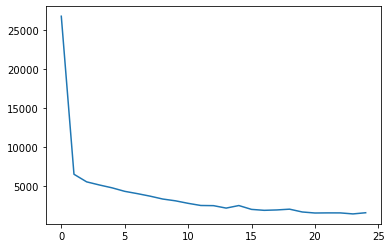

In [135]:
split_data =split_rnn(df,3)

x1_train,x2_train,y_train = split_data['train'] 

print('x1',x1_train.shape)
print('x2',x2_train.shape)
print('y',y_train.shape)
 
input1 = Input(shape=x1_train.shape[1])
input2 = Input(shape=x2_train.shape[1:])

layer1_rnn = LSTM(50,return_sequences=True,activation = 'relu')(input2)
layer2_rnn = LSTM(25,return_sequences=True,activation = 'relu')(layer1_rnn)
layer2_rnn = LSTM(10)(layer2_rnn)
layer1_dense = Dense(10)(input1) 
layer3 = Concatenate()([layer2_rnn,layer1_dense])
layer3 = Dense(10)(layer3)
output = Dense(1)(layer3)
model = Model(inputs=[input1,input2],outputs=[output])

print(model.summary())  

model.compile(optimizer='adam',
            loss='MeanSquaredError',
            metrics=['MeanSquaredError'])

history = model.fit([x1_train,x2_train],y_train,epochs=25)

plt.plot(history.history['loss'])
plt.show()

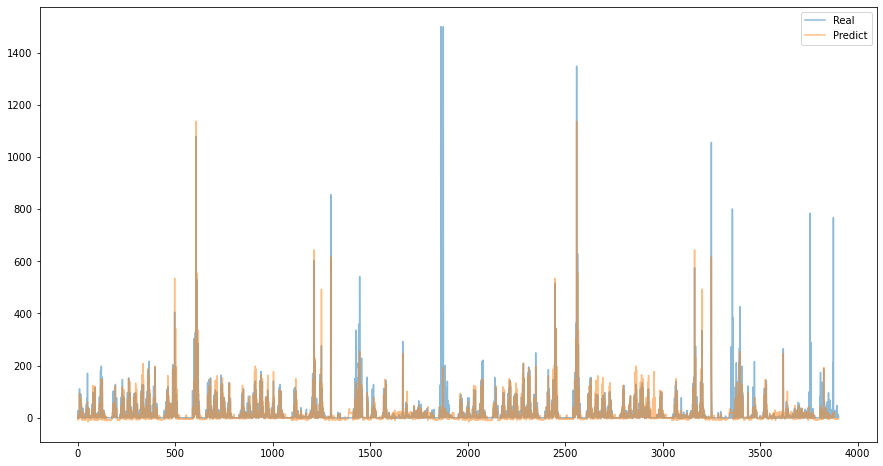

In [136]:
x1_test,x2_test,y_test = split_data['test']
y_pred = model.predict([x1_test,x2_test])


plt.figure(figsize=(15,8))
plt.plot(y_test,alpha=0.5,label = 'Real')
plt.plot(y_pred,alpha=0.5,label = 'Predict')
plt.legend()
plt.show()

In [147]:
def calculate_cost_of_sales(cost,expense,quantity,initial_inventory=0):
    '''
    cost_per_item = (cost_per_item+expense_per_item)*(quanrity_per_item+initial_inventory_per_item)
    '''
    return float((cost+expense)*(quantity+initial_inventory))

def calculate_expense(expense,quantity,initial_inventory=0):
    '''
    experse_per_item = expense_per_item*(quantity_per_item + initial_invrntory_per_item)
    '''
    return float(expense*(quantity+initial_inventory))

def eval(x,y_true,y_pred):
    price = x[:,2]
    base_price = price*0.87
    salary_per_employee = 5964
    employees = 2
    rental = 8500
    transportation = 500
    total_expense = (salary_per_employee*employees)+rental+transportation
    expense_per_item = (total_expense/(sum(y_test)))*60 # number_shops
    cost_sales_pred = []
    expense_pred = []
    for i,k in zip(base_price,y_pred):
        cost_sales_pred.append(calculate_cost_of_sales(i,expense_per_item,k))
        expense_pred.append(calculate_expense(expense_per_item,k))
    total_price = []
    for i, k in zip(price,y_pred):
        total_price.append(i*k)    
    gain_pred = []
    for i,k in zip(total_price,cost_sales_pred):
        gain_pred.append(i-k)
    error = []
    oportunidad =0
    mantenimiento = 0
    for i, k in zip(y_test,y_pred):
        error.append(i-k)
    for i in range(len(error)):
        if error[i]<0:
            oportunidad += float(gain_pred[i])
        else:
            mantenimiento += expense_pred[i]  
    print('Costo de oportunidad: ',oportunidad)
    print('Costo de mantenimiento: ',mantenimiento)
    plt.plot(expense_pred,alpha=0.5)
    plt.plot(gain_pred,alpha=0.5)
    plt.show()

Costo de oportunidad:  10061449.938105822
Costo de mantenimiento:  373246.619705995


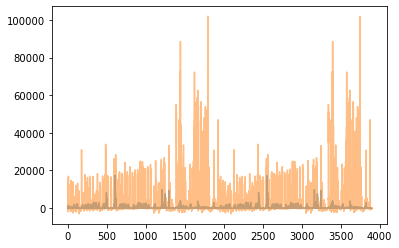

In [148]:
eval (x1_test,y_true,y_pred)

In [118]:
split_data =split_rnn(df,3)

x1_train,x2_train,y_train = split_data['train'] 

print(x2_train[:,:,0].shape)
print(y_train.shape)
estimator = RANSACRegressor(LinearRegression(),residual_threshold=1500.0,loss='absolute_loss')
param_grid = {'max_trials':[30,40,50,70,80,100,120,150],
            'min_samples':[20,100,200,300]}
#model = GridSearchCV(estimator, param_grid, cv = cv_plit, return_train_score=False)
model = GridSearchCV(estimator, param_grid, return_train_score=False)
print(model)
model = model.fit(x2_train[:,:,0],y_train)
result = pd.DataFrame(model.cv_results_)
print(result)
print(result.shape)
print(result.mean_test_score)
print(model.best_score_)
print(model.best_params_)

30
(56608, 3)
(56608, 1)
GridSearchCV(estimator=RANSACRegressor(base_estimator=LinearRegression(),
                                       residual_threshold=1500.0),
             param_grid={'max_trials': [30, 40, 50, 70, 80, 100, 120, 150],
                         'min_samples': [20, 100, 200, 300]})
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.012567      0.003313         0.000997    6.641573e-07   
1        0.010874      0.000659         0.000798    3.991131e-04   
2        0.010372      0.001353         0.000598    4.880327e-04   
3        0.011972      0.001888         0.000994    6.310132e-04   
4        0.009176      0.000398         0.000798    3.987556e-04   
5        0.009376      0.000798         0.000598    4.881105e-04   
6        0.011570      0.001954         0.000598    4.882273e-04   
7        0.012567      0.002054         0.000996    6.975526e-07   
8        0.010907      0.001712         0.000798    3.988506e-04   
9        0.01057

In [119]:
estimator = RANSACRegressor(LinearRegression(),residual_threshold=1500.0,loss='absolute_loss', max_trials=70,min_samples=20)
model = estimator.fit(x2_train[:,:,0],y_train)


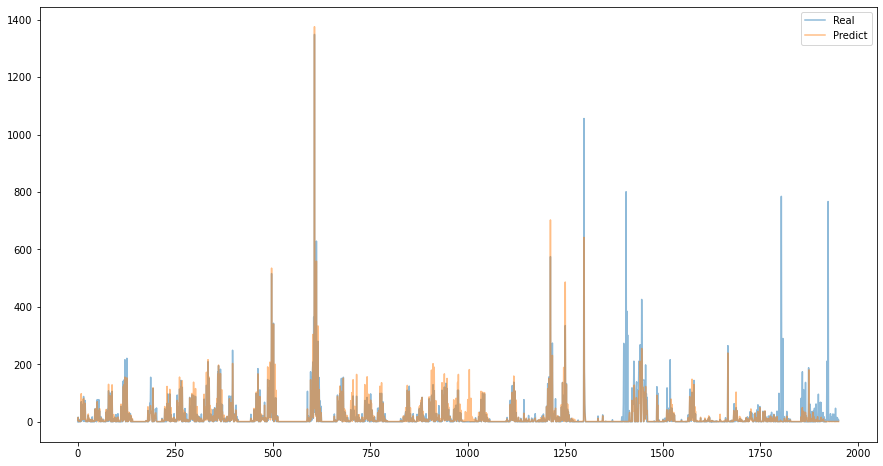

In [120]:
x1_test,x2_test,y_test = split_data['test'] 
y_pred_2=estimator.predict(x2_test[:,:,0])

plt.figure(figsize=(15,8))
plt.plot(y_test,alpha=0.5,label = 'Real')
plt.plot(y_pred_2,alpha=0.5,label = 'Predict')
plt.legend()
plt.show()